In [257]:
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm as tqdm
import pandas as pd

In [258]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [259]:
def potential_grad(sample, mu, cov):

    precision = jnp.linalg.inv(cov)

    return (sample - mu) @ precision

In [291]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=200, seed=0):
    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples

    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise

    return evolved_samples

In [292]:
def compute_moments_disc(samples, evolved_samples):

    mu_1 = jnp.mean(samples, axis=0)
    mu_2 = jnp.mean(evolved_samples, axis=0)

    centered_1 = samples - mu_1
    centered_2 = evolved_samples - mu_2

    cov_1 = centered_1.T @ centered_1 / samples.shape[0]
    cov_2 = centered_2.T @ centered_2 / evolved_samples.shape[0]

    loss_mu = jnp.sum((mu_1 - mu_2) ** 2)
    loss_cov = jnp.sum((cov_1 - cov_2) ** 2)

    return loss_mu + loss_cov

In [293]:
def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return compute_moments_disc(samples, evolved_samples)

In [294]:
def lm_optimize(samples, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov

In [295]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=200,
    use_lr_schedule=True
):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    # Define learning rate schedule (optional)
    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,     # valore iniziale piccolo
            end_value=base_lr,   # valore finale target
            transition_steps=500 # numero di step per raggiungerlo
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov, history


In [296]:
mu = jnp.array([0.0, 1.0, -1.0, 0.5, -0.5])

cov = jnp.array([
    [2.0,  0.4,  0.3,  0.2,  0.1],
    [0.4,  1.8,  0.2,  0.1,  0.2],
    [0.3,  0.2,  1.5,  0.3,  0.2],
    [0.2,  0.1,  0.3,  1.3,  0.4],
    [0.1,  0.2,  0.2,  0.4,  1.6]
])

In [297]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=250, base_lr=0.1, seed = 0)

epoch 0 | loss = 24.540907
epoch 200 | loss = 0.000001
epoch 249 | loss = 0.000000


In [298]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov), "\n\n\n")

[ 0.   1.  -1.   0.5 -0.5] 

 [-0.0274  0.9947 -0.9219  0.474  -0.4633] 0.09437682 



[[2.  0.4 0.3 0.2 0.1]
 [0.4 1.8 0.2 0.1 0.2]
 [0.3 0.2 1.5 0.3 0.2]
 [0.2 0.1 0.3 1.3 0.4]
 [0.1 0.2 0.2 0.4 1.6]] 

 [[1.9679 0.3031 0.2564 0.1887 0.1418]
 [0.3031 1.8314 0.2332 0.0873 0.1899]
 [0.2564 0.2332 1.4851 0.3092 0.3138]
 [0.1887 0.0873 0.3092 1.3425 0.3996]
 [0.1418 0.1899 0.3138 0.3996 1.7475]] 0.28456184 





In [299]:
history_np = {k: np.array(v) for k, v in history.items()}

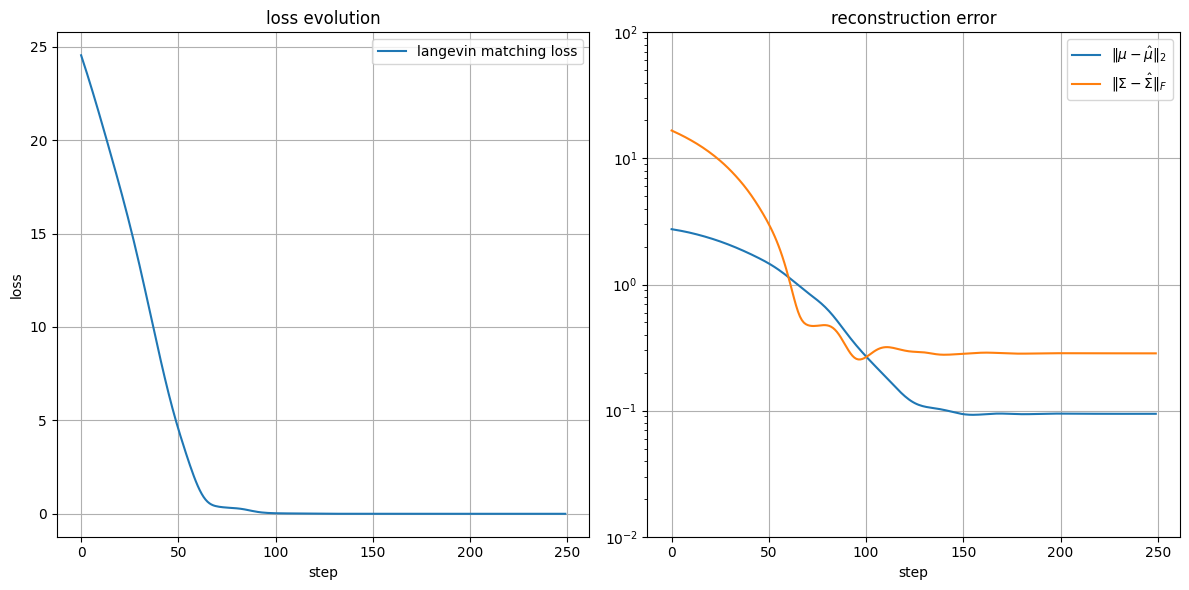

In [300]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="langevin matching loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss evolution")
plt.grid(True)
plt.legend()

ymin_recon = 1e-2
ymax_recon = 100.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step")
plt.title("reconstruction error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [301]:
history_np["mu_l2"]

array([2.7474, 2.7311, 2.7145, 2.6977, 2.6806, 2.663 , 2.6447, 2.6256,
       2.6058, 2.5853, 2.5641, 2.5424, 2.5202, 2.4975, 2.4744, 2.4509,
       2.427 , 2.4026, 2.3779, 2.3528, 2.3273, 2.3015, 2.2752, 2.2487,
       2.2217, 2.1945, 2.1669, 2.139 , 2.1109, 2.0825, 2.0539, 2.0251,
       1.9961, 1.9669, 1.9377, 1.9084, 1.879 , 1.8496, 1.8202, 1.7908,
       1.7615, 1.7322, 1.7031, 1.6739, 1.6449, 1.6158, 1.5867, 1.5574,
       1.528 , 1.4983, 1.4682, 1.4376, 1.4066, 1.3751, 1.3432, 1.3109,
       1.2783, 1.2455, 1.2126, 1.1799, 1.1473, 1.1152, 1.0835, 1.0524,
       1.0221, 0.9927, 0.9642, 0.9368, 0.9105, 0.8852, 0.861 , 0.8378,
       0.8153, 0.7934, 0.7718, 0.7503, 0.7287, 0.7068, 0.6844, 0.6615,
       0.6382, 0.6145, 0.5905, 0.5664, 0.5424, 0.5187, 0.4954, 0.4728,
       0.4511, 0.4303, 0.4106, 0.392 , 0.3746, 0.3582, 0.343 , 0.3287,
       0.3152, 0.3027, 0.2908, 0.2796, 0.269 , 0.2589, 0.2493, 0.2402,
       0.2314, 0.2231, 0.215 , 0.2073, 0.1998, 0.1926, 0.1857, 0.1789,
      

In [302]:
history_np["cov_fro"]

array([16.65  , 16.3797, 16.1118, 15.844 , 15.575 , 15.3039, 15.0304,
       14.7547, 14.4771, 14.1981, 13.9182, 13.6375, 13.3557, 13.0723,
       12.7868, 12.4994, 12.2103, 11.92  , 11.6286, 11.3365, 11.0438,
       10.7507, 10.4574, 10.1641,  9.8707,  9.5773,  9.284 ,  8.9909,
        8.6979,  8.4054,  8.1139,  7.8239,  7.5362,  7.2513,  6.9696,
        6.6913,  6.4163,  6.1443,  5.8749,  5.608 ,  5.344 ,  5.0835,
        4.8275,  4.5769,  4.3325,  4.095 ,  3.8647,  3.6414,  3.4248,
        3.2139,  3.008 ,  2.8059,  2.6069,  2.4106,  2.2169,  2.0263,
        1.8395,  1.6578,  1.4827,  1.3158,  1.1591,  1.0149,  0.8858,
        0.7741,  0.6819,  0.61  ,  0.5576,  0.5219,  0.499 ,  0.4851,
        0.4768,  0.472 ,  0.4696,  0.4689,  0.4696,  0.4711,  0.4731,
        0.475 ,  0.4763,  0.4763,  0.4745,  0.4702,  0.4629,  0.4523,
        0.4384,  0.4214,  0.402 ,  0.3809,  0.3591,  0.3378,  0.3178,
        0.2998,  0.2845,  0.2722,  0.2632,  0.2574,  0.2547,  0.2546,
        0.2567,  0.2